In [1]:
import sys
# sys.path.insert(0, '/Users/sbredenk/Repos/CORAL_nesc/CORAL')
sys.path.insert(0, '/Users/sbredenk/Repos/ORBIT_semitaut/ORBIT')
from CORAL import SharedLibrary, GlobalManager, Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import yaml
import os

ne = ['MA','ME','CT','RI','NH','RI/CT']

In [2]:
base = os.path.join(os.getcwd(), "analysis", "configs", "base.yaml")
base_float = os.path.join(os.getcwd(), "analysis", "configs", "base_float.yaml")
library = os.path.join(os.getcwd(), "analysis", "library")

In [3]:
base_baseline = os.path.join(os.getcwd(), "analysis", "pipelines", "base_baseline_pipeline.csv")
pipeline = Pipeline(base_baseline, base, base_float, enforce_feeders=True)

allocations = {
    "wtiv": [('example_heavy_lift_vessel', 2),('example_wtiv', 2)],
    "feeder": ('example_heavy_feeder', 6),
    "port": [('new_london', 1), ('new_bedford', 1), ('sbmt', 1), ('njwp', 1), ('searsport', 1), ('tradepoint', 1), ('portsmouth', 1), ('salem', 1)],
    "ahts_vessel": ('example_ahts_vessel', 2),
    "towing_vessel": ('example_towing_vessel', 2),
}
print(pipeline)

In [4]:
wtiv_dates = [dt.date(2025,1,1), dt.date(2030,1,1)]
manager = GlobalManager(pipeline.configs, allocations, library_path=library)
manager.add_future_resources('wtiv', 'example_wtiv', wtiv_dates)
manager.add_future_resources('wtiv', 'example_heavy_lift_vessel', wtiv_dates)
manager.run()

ORBIT library intialized at 'c:\Users\sbredenk\Repos\ORBIT_semitaut\ORBIT\library'


In [5]:
manager.library

In [34]:
df = pd.DataFrame(manager.logs).iloc[::-1]
df = df.reset_index(drop=True).reset_index()
# df['estimate_cod'] = np.zeros(len(df))
# df_pipeline = pd.read_csv(base_baseline)
# display(df_pipeline)

# for i,row in df.iterrows():
#     cod = df_pipeline.loc[df_pipeline]
#     df['estimated_cod'][i] = cod

In [35]:
sub_map = pipeline.projects[["name", "substructure"]].set_index("name").to_dict()['substructure']
df['substructure'] = [sub_map[name] for name in df['name']]

cod_map = pipeline.projects[["name", "estimated_cod"]].set_index("name").to_dict()['estimated_cod']
df['estimated_cod'] = [cod_map[name] for name in df['name']]
df['estimated_cod'] = pd.to_datetime(df['estimated_cod'], format='%Y')

state_map = pipeline.projects[["name", "location"]].set_index("name").to_dict()['location']
df['offtake_state'] = [state_map[name] for name in df['name']]

port_map = pipeline.projects[["name", "associated_port"]].set_index("name").to_dict()['associated_port']
df['port'] = [port_map[name] for name in df['name']]

df = df.replace('semisub','floating')
df = df.replace('monopile','fixed')
df = df.replace('jacket', 'fixed')
display(df)

# df = df.drop(columns=['index'])

# display(df[df['offtake_state'].isin(ne)].reset_index(drop=True).reset_index())

,index,name,Initialized,Started,Finished,Date Initialized,Date Started,Date Finished,substructure,estimated_cod,offtake_state,port
0,0,Hypothetical Gulf of Maine Draft WEA 3,157800,253708.427273,269867.589610,2041-01-01,2051-12-11 05:00:00,2053-10-14 12:00:00,floating,2042-01-01,ME,searsport
1,1,Hypothetical Gulf of Maine Draft WEA 2,157800,237549.264935,253708.427273,2041-01-01,2050-02-05 22:00:00,2051-12-11 05:00:00,floating,2042-01-01,ME,searsport
2,2,Hypothetical NY Bight Floating 1,149016,217190.102597,237549.264935,2040-01-01,2047-10-11 15:00:00,2050-02-05 22:00:00,floating,2041-01-01,NY,searsport
3,3,Hypothetical Gulf of Maine Draft WEA 4,157800,220808.475974,236967.638312,2041-01-01,2048-03-10 09:00:00,2050-01-12 16:00:00,floating,2042-01-01,NH,tradepoint
4,4,Hypothetical NE Floating 3,149016,203809.313636,220808.475974,2040-01-01,2046-04-02 02:00:00,2048-03-10 09:00:00,floating,2041-01-01,RI,tradepoint
...,...,...,...,...,...,...,...,...,...,...,...,...
66,66,Atlantic Shores Offshore Wind South 1,26304,26304.000000,34396.651649,2026-01-01,2026-01-01 00:00:00,2026-12-04 05:00:00,fixed,2027-01-01,NJ,njwp
67,67,MarWin,26304,26304.000000,27626.367537,2026-01-01,2026-01-01 00:00:00,2026-02-25 03:00:00,fixed,2027-01-01,MD,tradepoint
68,68,Revolution Wind 1,8760,8760.000000,13120.005162,2024-01-01,2024-01-01 00:00:00,2024-06-30 17:00:00,fixed,2025-01-01,RI/CT,new_london
69,69,Vineyard Wind 1,0,0.000000,4576.978530,2023-01-01,2023-01-01 00:00:00,2023-07-10 17:00:00,fixed,2024-01-01,MA,new_bedford


71
71


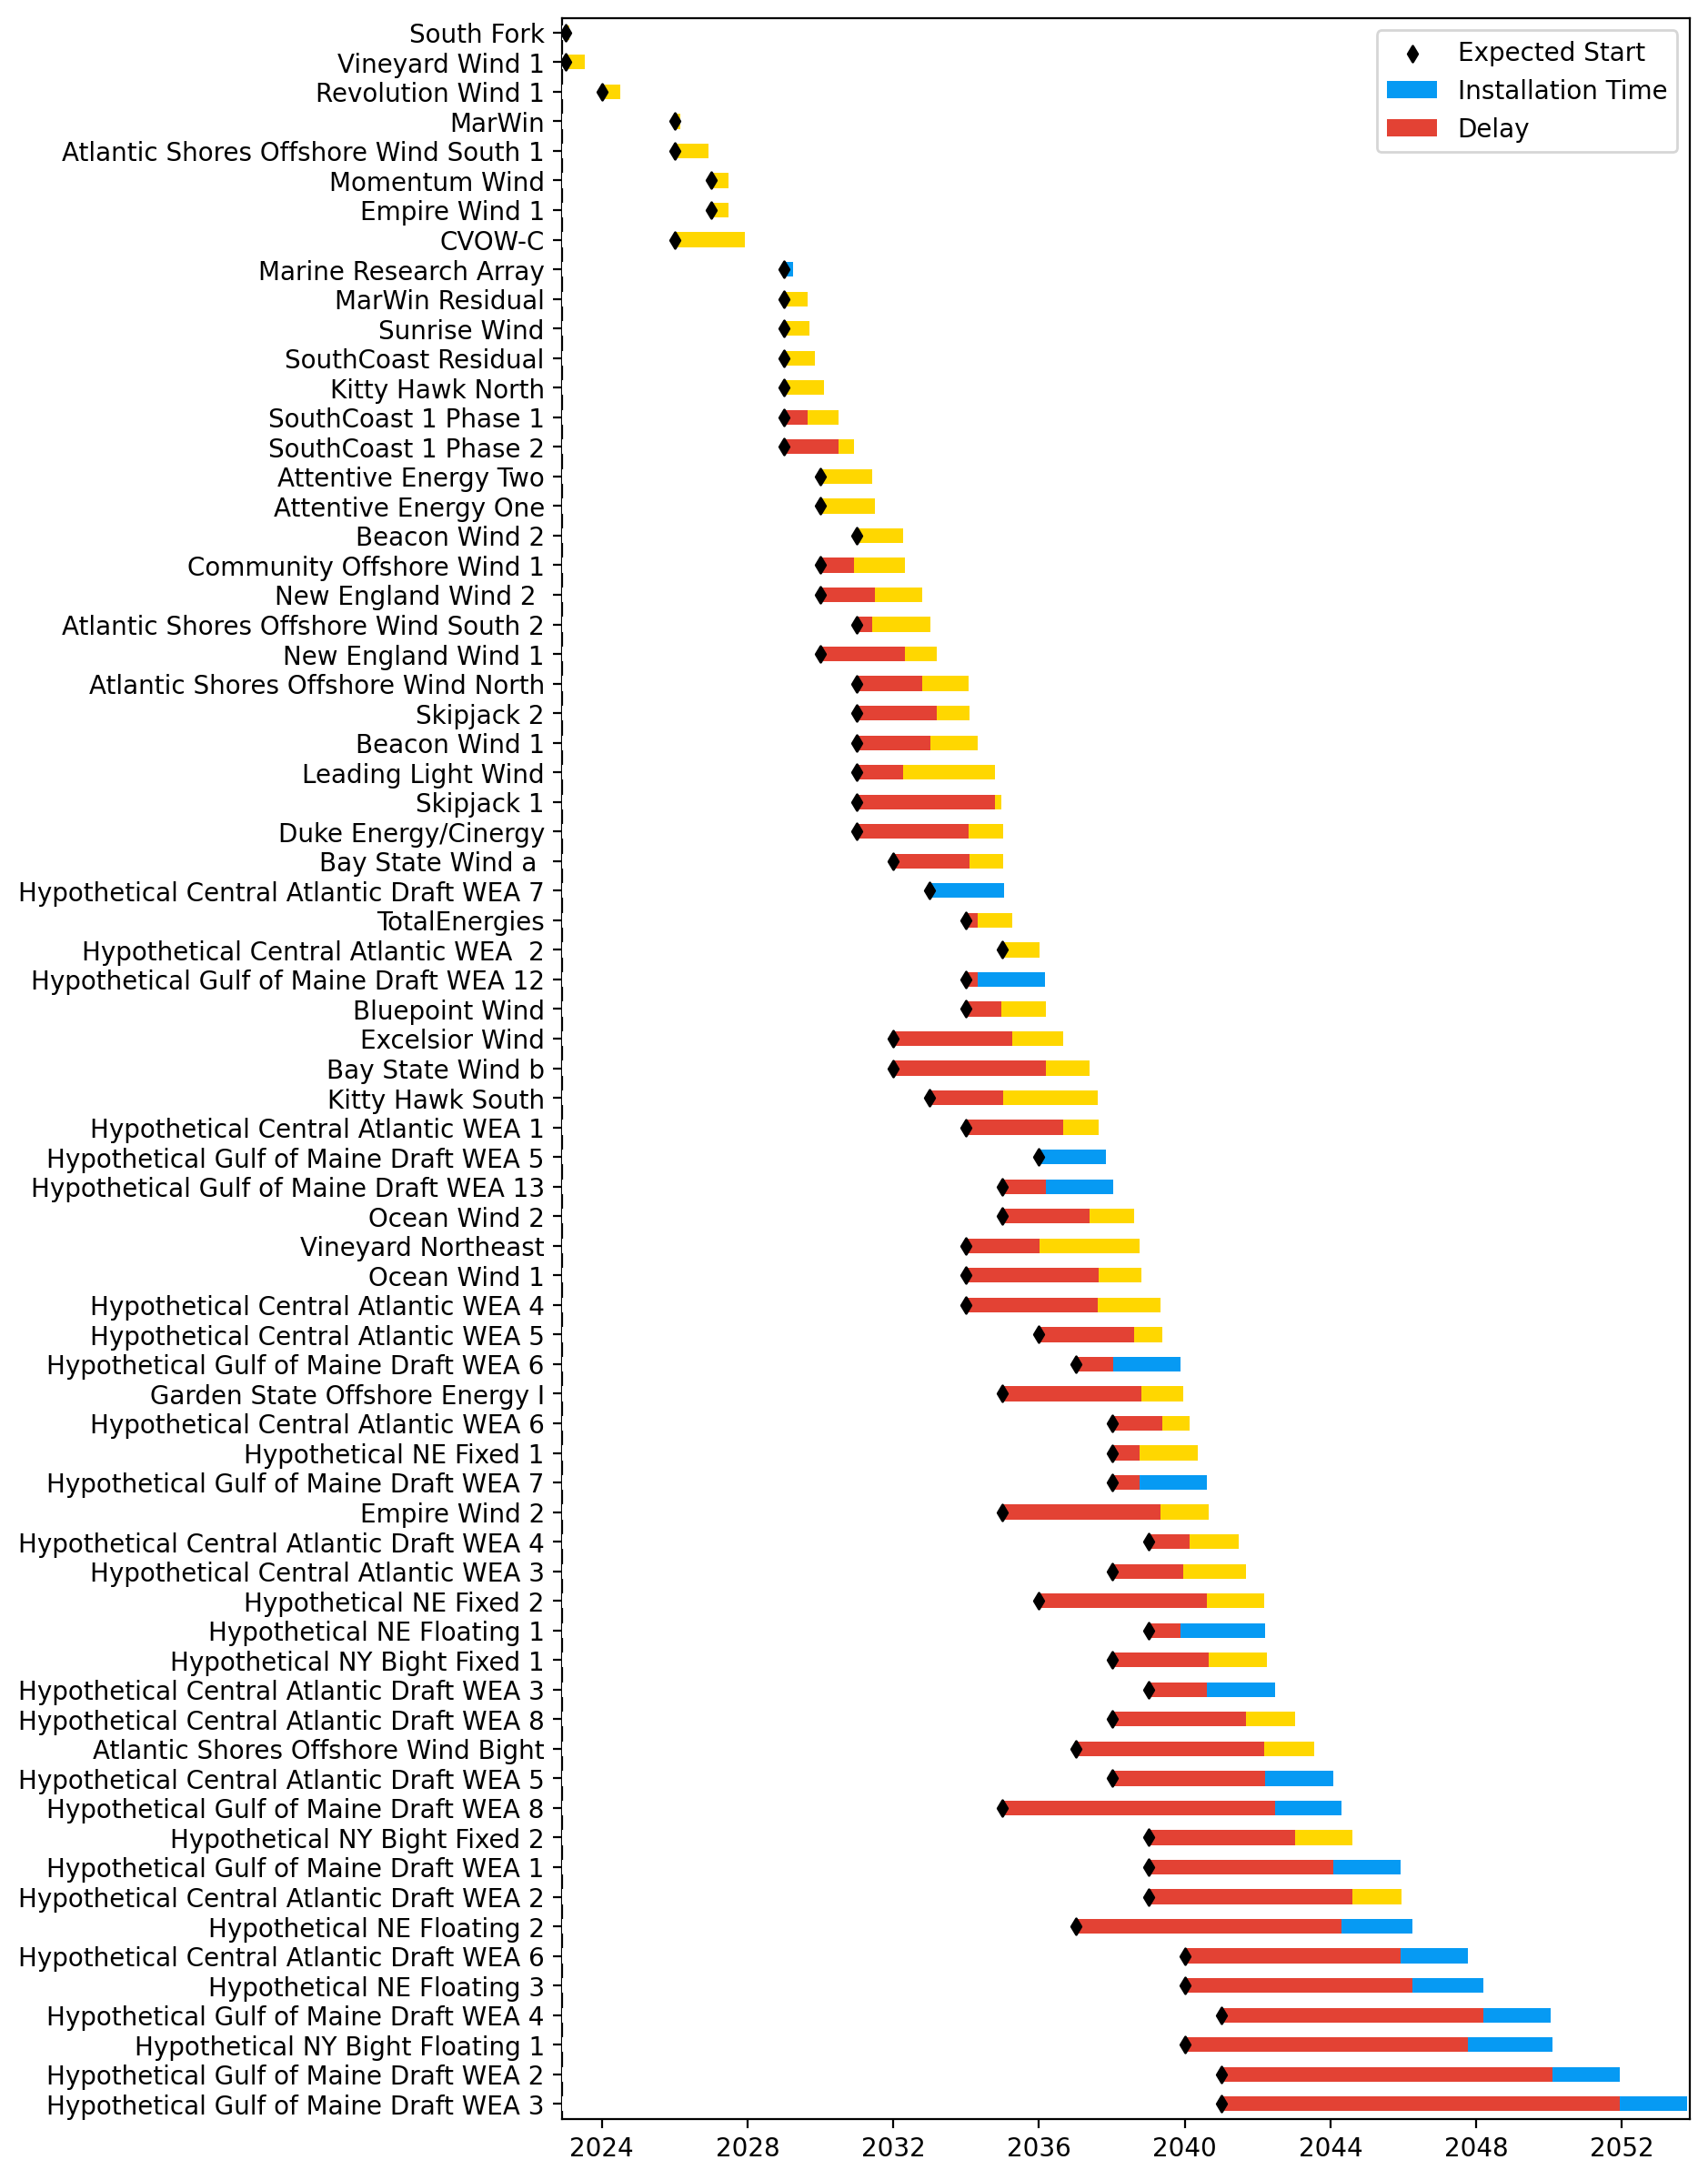

In [40]:
fig = plt.figure(figsize=(8, len(df)/4), dpi=200)
ax = fig.add_subplot(111)

color_map = {
    "fixed": "#FFD700",
    "floating": "#069AF3",
}
bar_color = []
for i,row in df.iterrows():
    if row['substructure'] == 'fixed':
        bar_color.append("#FFD700")
    else:
        bar_color.append("#069AF3")

print(len(df))
print(len(bar_color))

df["Date Finished"].plot(kind="barh", ax=ax, zorder=4, label="Installation Time", color=bar_color)
df["Date Started"].plot(kind="barh", ax=ax, zorder=4, label="Delay", color="#E34234")
df["Date Initialized"].plot(kind="barh", color="w", ax=ax, zorder=4, label="__nolabel__")

df.plot(kind="scatter", x="Date Initialized", y="index", color='k', ax=ax, zorder=5, label="Expected Start", marker="d")
 
# groups = df.groupby("substructure")
# for name, group in groups:
#     group.plot(kind="scatter", x="Date Started", y="index", ax=ax, marker=">", c=color_map[name], zorder=5, label=name.capitalize())

ax.set_xlabel("")
ax.set_ylabel("")
_ = ax.set_yticklabels(df['name'])

ax.legend()

ax.set_xlim(manager._start - dt.timedelta(days=30), df["Date Finished"].max() + dt.timedelta(days=30))
plt.savefig('analysis/results/test_418_double.png')

In [9]:
region = ['MA','ME','CT','RI','NH','RI/CT']
region_name = 'New England'

df_region = df.drop(columns=['index'])
df_region = df_region[df_region['offtake_state'].isin(region)].reset_index(drop=True).reset_index()

(19328.0, 30632.5)

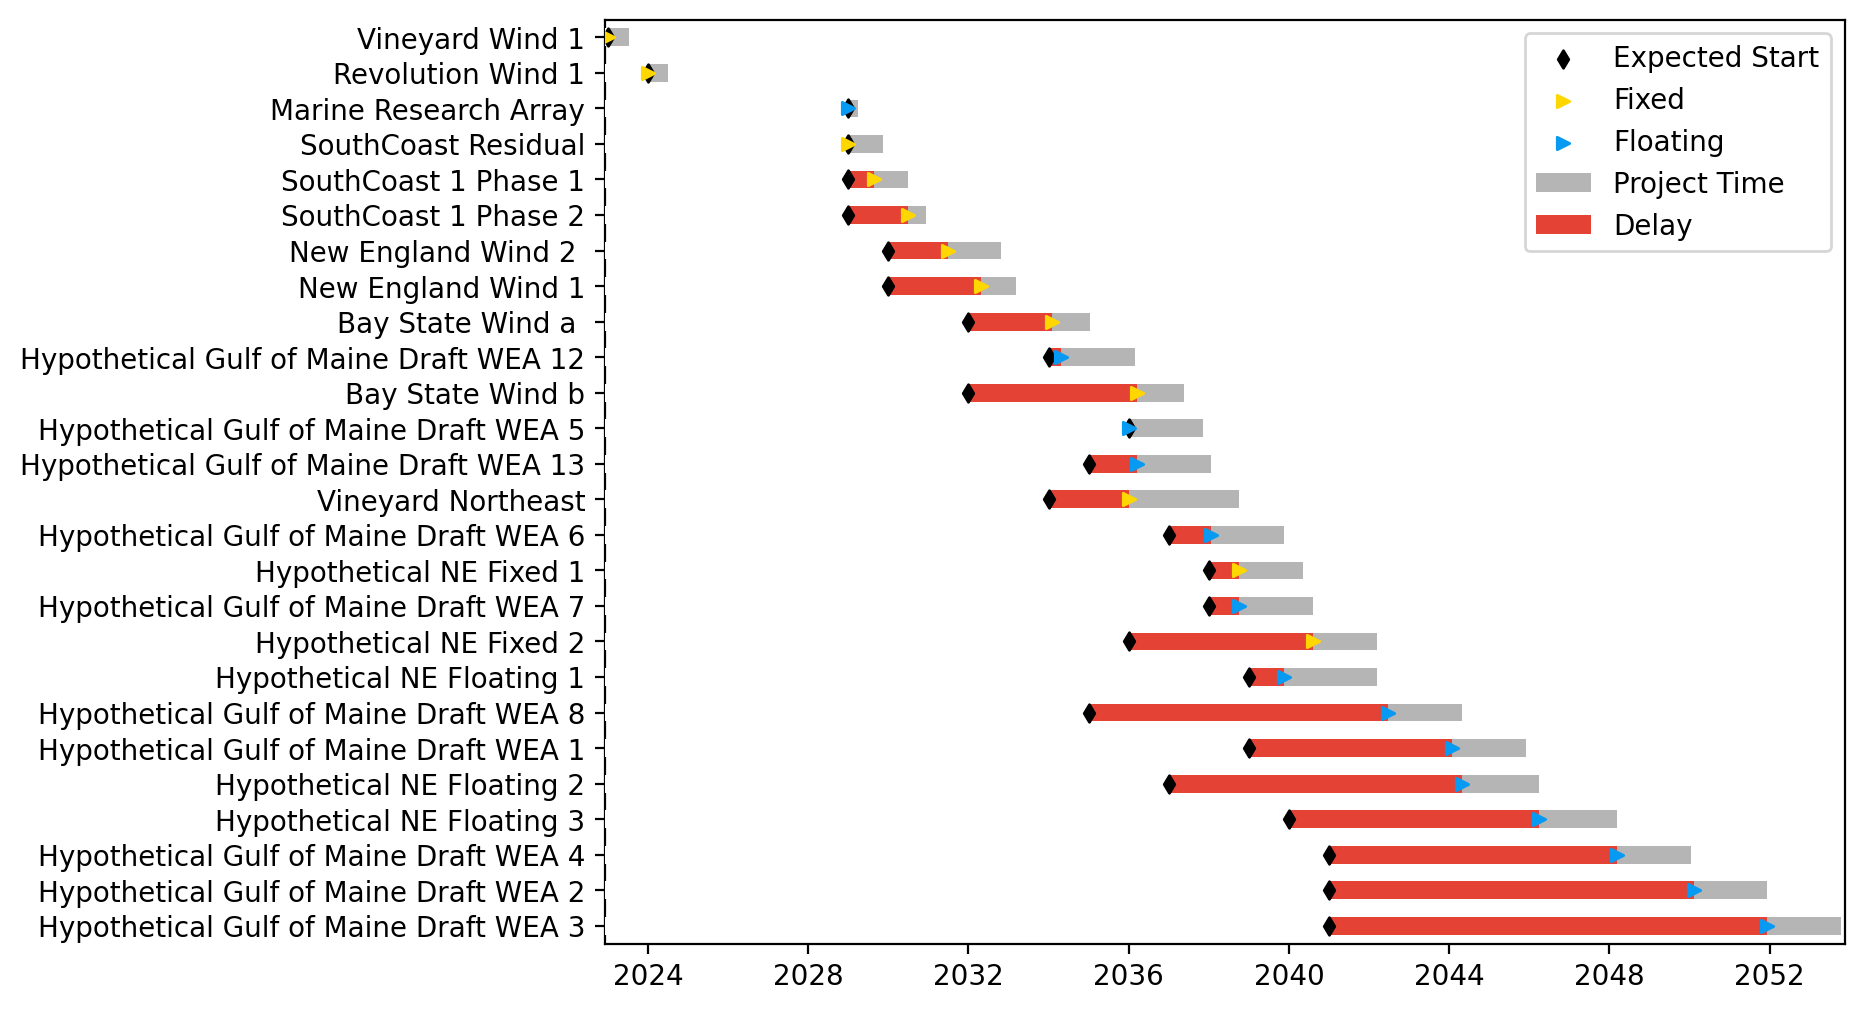

In [10]:
fig = plt.figure(figsize=(8, 6), dpi=200)
ax = fig.add_subplot(111)

color_map = {
    "fixed": "#FFD700",
    "floating": "#069AF3",
}

df_region["Date Finished"].plot(kind="barh", ax=ax, zorder=4, label="Project Time", color='#B5B5B5')
df_region["Date Started"].plot(kind="barh", color="#E34234", ax=ax, zorder=4, label="Delay")
df_region["Date Initialized"].plot(kind='barh', ax=ax, zorder=4, label = "__nolabel__", color = 'w')

df_region.plot(kind="scatter", x="Date Initialized", y="index", color='k', ax=ax, zorder=5, label="Expected Start", marker="d")

groups = df_region.groupby("substructure")
for name, group in groups:
    group.plot(kind="scatter", x="Date Started", y="index", ax=ax, marker=">", c=color_map[name], zorder=5, label=name.capitalize())

ax.set_xlabel("")
ax.set_ylabel("")
_ = ax.set_yticklabels(df_region['name'])

ax.legend()

ax.set_xlim(manager._start - dt.timedelta(days=30), df_region["Date Finished"].max() + dt.timedelta(days=30))

# slide = add_to_pptx(prs,'%s Gantt' % region_name)
# print('%s Gantt Complete' % region_name)

In [13]:
df_ports = df.drop(columns=['index'])
df_njwp = df_ports[df_ports['port'] == 'njwp'].reset_index(drop=True).reset_index()
df_sbmt = df_ports[df_ports['port'] == 'sbmt'].reset_index(drop=True).reset_index()
df_nb = df_ports[df_ports['port'] == 'new_bedford'].reset_index(drop=True).reset_index()
df_nl = df_ports[df_ports['port'] == 'new_london'].reset_index(drop=True).reset_index()
df_portsmouth = df_ports[df_ports['port'] == 'portsmouth'].reset_index(drop=True).reset_index()
df_mat = df_ports[df_ports['port'] == 'tradepoint'].reset_index(drop=True).reset_index()
# df_salem = df_ports[df_ports['port'] == 'salem'].reset_index(drop=True).reset_index()
df_searsport = df_ports[df_ports['port'] == 'searsport'].reset_index(drop=True).reset_index()

(19328.0, 28437.625)

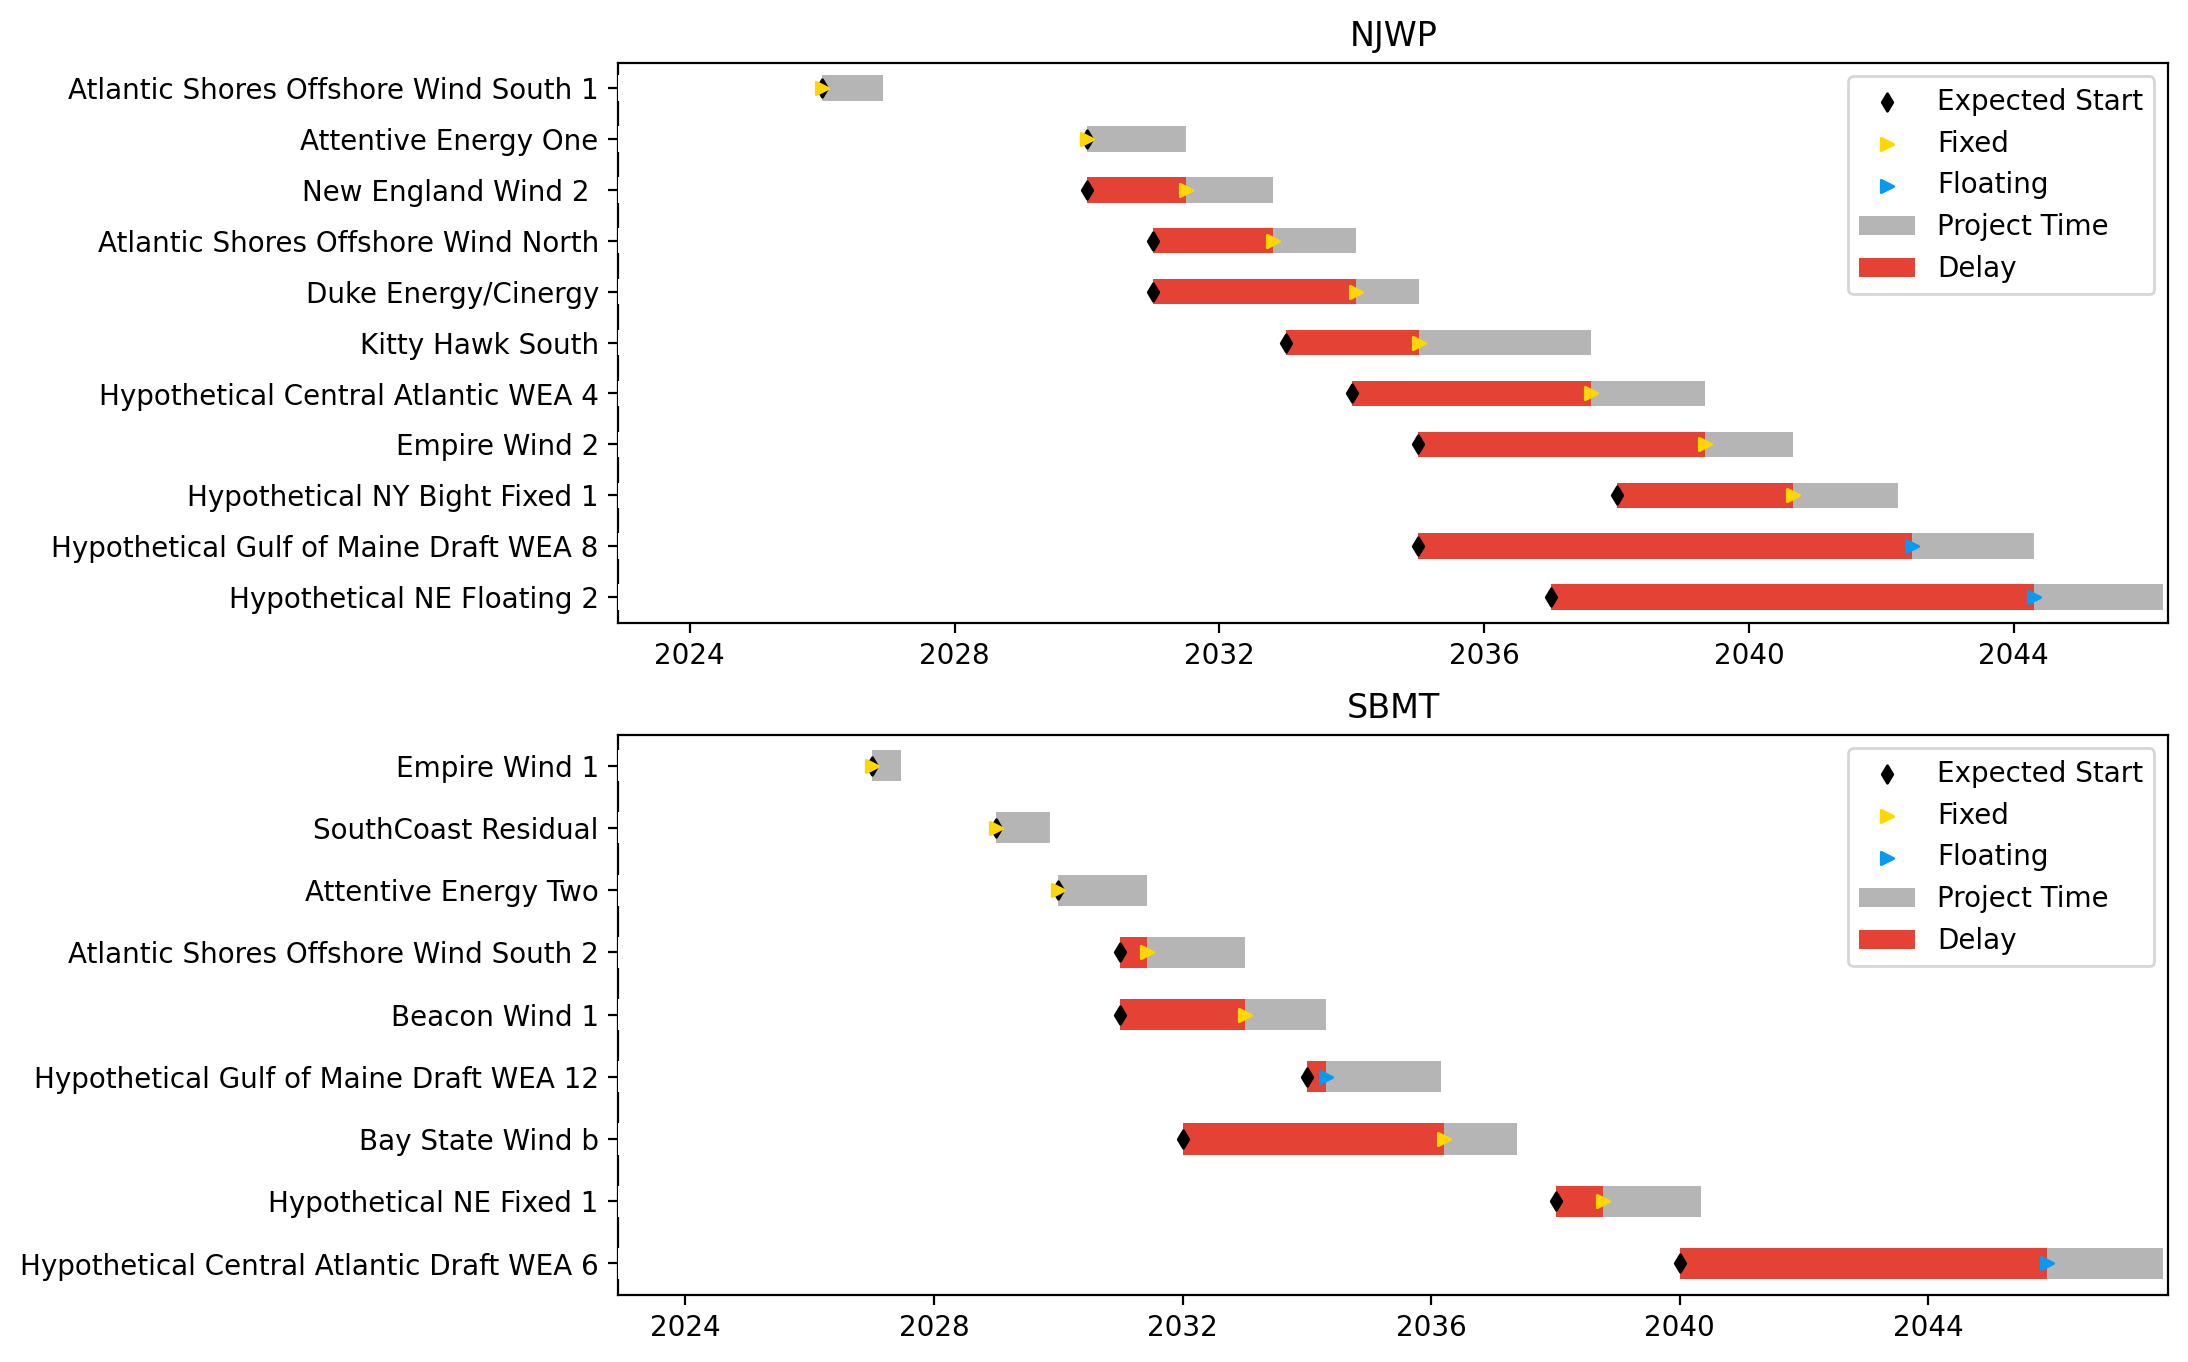

In [23]:
fig = plt.figure(figsize=(10, 8), dpi=200)

ax = fig.add_subplot(211)

color_map = {
    "fixed": "#FFD700",
    "floating": "#069AF3",
}

df_njwp["Date Finished"].plot(kind="barh", ax=ax, zorder=4, label="Project Time", color='#B5B5B5')
df_njwp["Date Started"].plot(kind="barh", color="#E34234", ax=ax, zorder=4, label="Delay")
df_njwp["Date Initialized"].plot(kind='barh', ax=ax, zorder=4, label = "__nolabel__", color = 'w')

df_njwp.plot(kind="scatter", x="Date Initialized", y="index", color='k', ax=ax, zorder=5, label="Expected Start", marker="d")

groups = df_njwp.groupby("substructure")
for name, group in groups:
    group.plot(kind="scatter", x="Date Started", y="index", ax=ax, marker=">", c=color_map[name], zorder=5, label=name.capitalize())

ax.set_xlabel("")
ax.set_ylabel("")
_ = ax.set_yticklabels(df_njwp['name'])
ax.set_title("NJWP")

ax.legend()

ax.set_xlim(manager._start - dt.timedelta(days=30), df_njwp["Date Finished"].max() + dt.timedelta(days=30))

ax = fig.add_subplot(212)

color_map = {
    "fixed": "#FFD700",
    "floating": "#069AF3",
}

df_sbmt["Date Finished"].plot(kind="barh", ax=ax, zorder=4, label="Project Time", color='#B5B5B5')
df_sbmt["Date Started"].plot(kind="barh", color="#E34234", ax=ax, zorder=4, label="Delay")
df_sbmt["Date Initialized"].plot(kind='barh', ax=ax, zorder=4, label = "__nolabel__", color = 'w')

df_sbmt.plot(kind="scatter", x="Date Initialized", y="index", color='k', ax=ax, zorder=5, label="Expected Start", marker="d")

groups = df_sbmt.groupby("substructure")
for name, group in groups:
    group.plot(kind="scatter", x="Date Started", y="index", ax=ax, marker=">", c=color_map[name], zorder=5, label=name.capitalize())

ax.set_xlabel("")
ax.set_ylabel("")
_ = ax.set_yticklabels(df_sbmt['name'])
ax.set_title("SBMT")

ax.legend()

ax.set_xlim(manager._start - dt.timedelta(days=30), df_sbmt["Date Finished"].max() + dt.timedelta(days=30))

searsport
new_bedford
new_london
njwp
sbmt
tradepoint
portsmouth


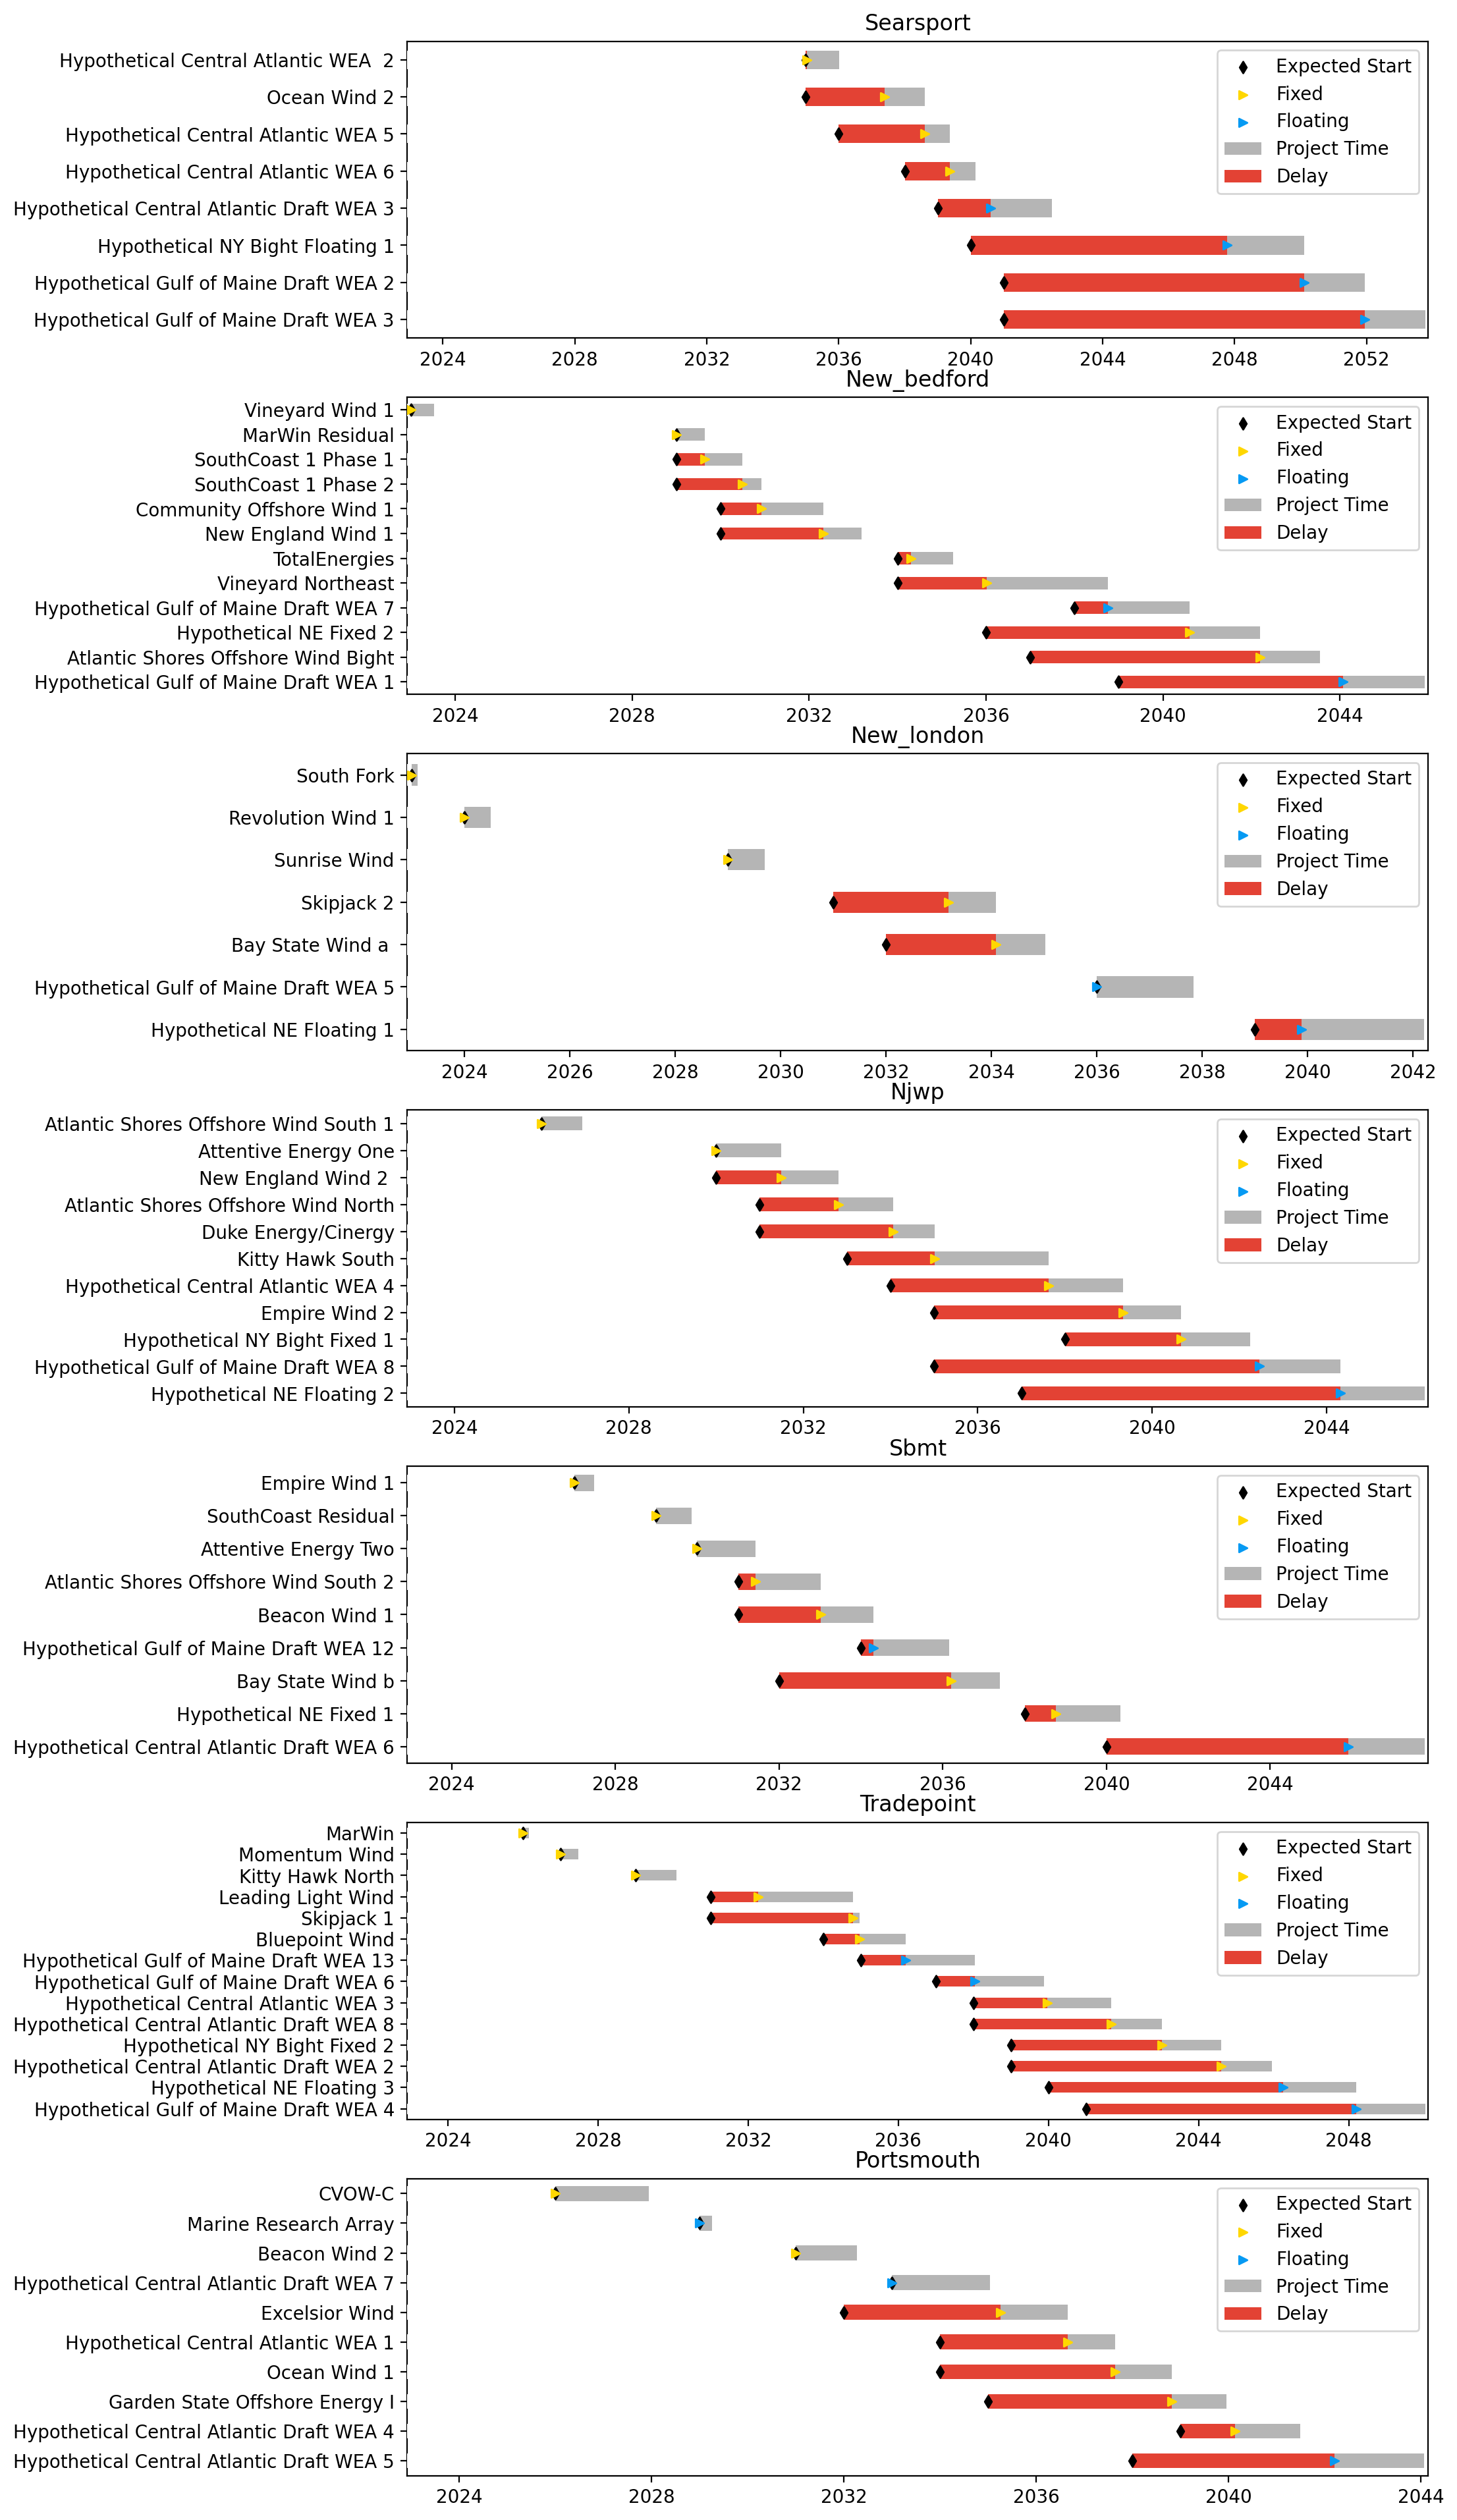

In [33]:
ports = ['searsport', 'new_bedford', 'new_london', 'njwp', 'sbmt', 'tradepoint', 'portsmouth']
i = 1
fig = plt.figure(figsize=(10, 24), dpi=200)
df_ports = df.drop(columns=['index'])
num_ports = len(ports)

for port in ports:
    df_port = df_ports[df_ports['port'] == port].reset_index(drop=True).reset_index()

    ax = fig.add_subplot(num_ports,1,i)
    color_map = {
        "fixed": "#FFD700",
        "floating": "#069AF3",
    }

    df_port["Date Finished"].plot(kind="barh", ax=ax, zorder=4, label="Project Time", color='#B5B5B5')
    df_port["Date Started"].plot(kind="barh", color="#E34234", ax=ax, zorder=4, label="Delay")
    df_port["Date Initialized"].plot(kind='barh', ax=ax, zorder=4, label = "__nolabel__", color = 'w')

    df_port.plot(kind="scatter", x="Date Initialized", y="index", color='k', ax=ax, zorder=5, label="Expected Start", marker="d")

    groups = df_port.groupby("substructure")
    for name, group in groups:
        group.plot(kind="scatter", x="Date Started", y="index", ax=ax, marker=">", c=color_map[name], zorder=5, label=name.capitalize())

    ax.set_xlabel("")
    ax.set_ylabel("")
    _ = ax.set_yticklabels(df_port['name'])
    ax.set_title(port.capitalize())

    ax.legend()

    ax.set_xlim(manager._start - dt.timedelta(days=30), df_port["Date Finished"].max() + dt.timedelta(days=30))

    i += 1
    print(port)

In [11]:
;l

NameError: name 'l' is not defined